In [1]:
# Installing necessary libraries
!pip install python-resize-image
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/CS156/Landmark/PXL_20220930_233903824.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_172457716.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220929_150809452.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_151825834.MP.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_213728864.MP.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_162236141.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_220115750.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220929_165923879.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220929_154304217.MP.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_141007817.MP.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220929_150807880.MP.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_233856440.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_213730580.MP.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_172503059.jpg
/content/drive/MyDrive/CS156/Landmark/PXL_20220930_220117367.jpg
/conten

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Total Images: 20
Images Shape: (20, 786432)


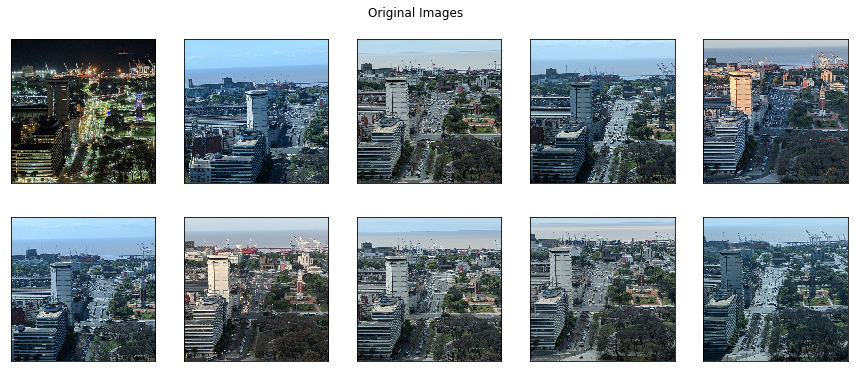

In [2]:


# resize and crop images
def preprocess(images, dims):
    '''
    Resizes and crops images using the function given
    in the Session 7 repo from load_images.py.
    '''    

    flattened = []
    # for each image path
    for path in images:
        print(path)
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, dims)
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), 0))


    # Flatten it once more
    flattened = np.asarray(flattened)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    # return resized images
    return X, Y

# resize images using function
path = "/content/drive/MyDrive/CS156/Landmark"
file = glob("/content/drive/MyDrive/CS156/Landmark/*")

# Desired dimensions
dims = (512, 512)
images = preprocess(file, dims)[0]

# Summary stats
N = len(images)
print(f'Total Images: {N}')
print(f'Images Shape: {images.shape}')

# plot samples of original images
fig = plt.figure(figsize=(15, 6)) 

for i in range(10): 
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[]) 
    img = Image.fromarray(images[i].reshape(dims[0],dims[1],3), 'RGB') 
    ax.imshow(img, interpolation='nearest') 
    
plt.suptitle('Original Images', y=0.95)

plt.show()

(20, 20)


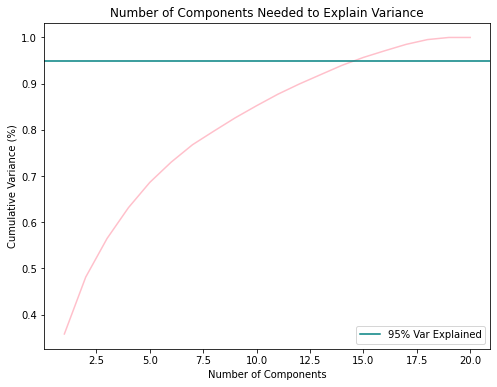

In [3]:


from sklearn import decomposition
# apply PCA using all components
n_components = N
pca = decomposition.PCA(n_components=n_components)

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

print(transformed.shape)
# plot number of components vs. explained variance
plt.figure(figsize=(8,6))

components = np.arange(1, n_components+1, step=1)
var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, var, color='pink')
plt.axhline(y=0.95, color='teal', label='95% Var Explained')

plt.title('Number of Components Needed to Explain Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')

plt.legend(loc=4)
plt.show()


From the curve above we see that nearly half (48.1%) of the variance is explained by the two first components. The slope of the curve indicates how much explanatory power each additional component adds. In the beggining it is relatively steep, but it quickly flattens out, showing that after the first few components there is not much variance that can be explained by adding one extra component. 

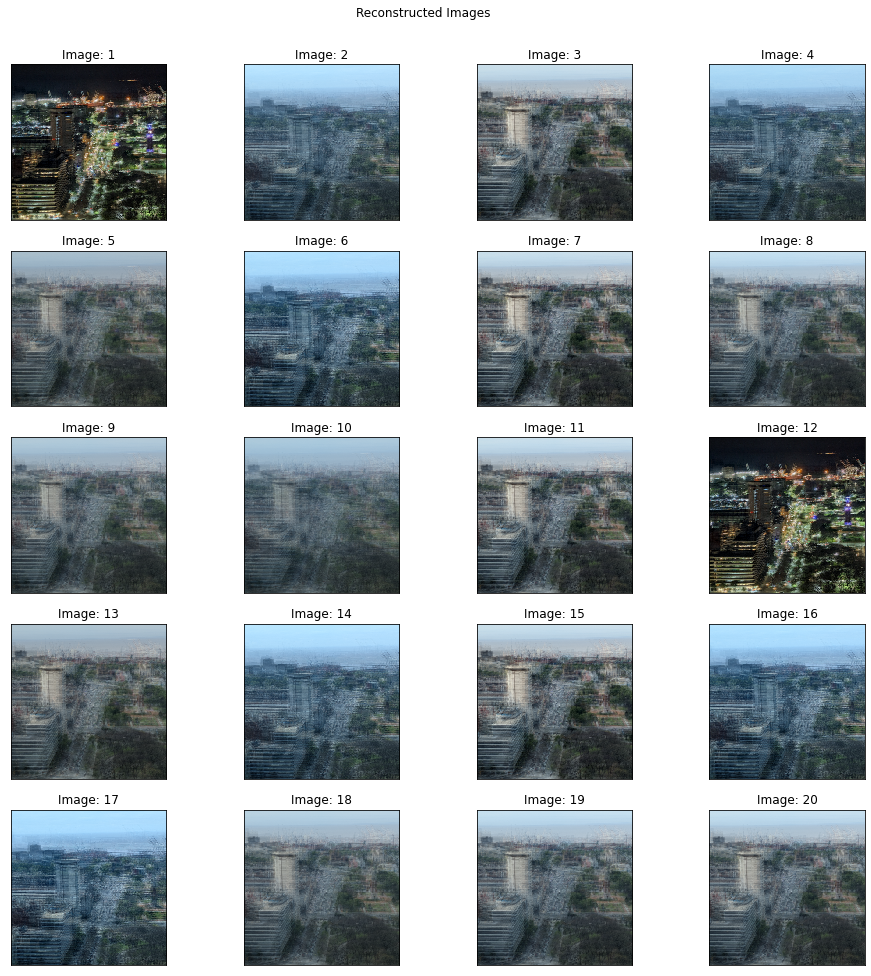

In [4]:

def train_model(model, data):

    transformed = model.fit_transform(data)

    return transformed

# transform image to save samples
def format_transformed_images(transformed):
    inverse = pca.inverse_transform(transformed)
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)

    # print each image

    # reshape formatted samples
    reshaped = []
    if len(formatted.shape)>1:
        for i in formatted:
            new_img = Image.fromarray(i.reshape(dims[0],dims[1],3), 'RGB')
            reshaped.append(new_img)
    else:
            new_img = Image.fromarray(formatted.reshape(dims[0],dims[1],3), 'RGB')
            reshaped.append(new_img)
    return reshaped


    
# apply PCA
pca = decomposition.PCA(n_components=2)

# fit images to PCA to reduce dimensions
transformed = train_model(pca, images)

reshaped = format_transformed_images(transformed)

# plot samples

def plot_reconstructed(reshaped_images, title = "", custom_titles = None ):
    fig = plt.figure(figsize=(16, 20)) 

    for i in range(len(reshaped_images)): 
        ax = fig.add_subplot(6, 4, i+1, xticks=[], yticks=[]) 
        ax.imshow(reshaped_images[i], interpolation='nearest')
        if not custom_titles:
            ax.set_title(f'Image: {i+1}')
        else:
            ax.set_title(f'{custom_titles[i]}')
        
    plt.suptitle(title, y=0.92)

    plt.show()

plot_reconstructed(reshaped, 'Reconstructed Images')

The image reconstruction is pretty decent. We can clearly see the two pictures that were taken at night and we can somewhat tell the difference between pictures taken on one day and the other (the second day was clearer so the images are bluer). We can't really tell which images were taken at sunset.

In [5]:
import plotly.express as px

# Visualizing the locations of the transformed images in 2d space
def visualize_vector_space(transformed):
    dimensions = len(transformed[0])
    labels = {
            str(i): f"PC {i+1} ({var:.1f}%)"
            for i, var in enumerate(pca.explained_variance_ratio_ * 100)
            }
    # If there are only two dimensions, make a simple 2d plot
    if  dimensions == 2:
        fig = px.scatter(
        transformed, x = 0, y = 1, labels = labels)
    # Otherwise, make a matrix of scatterplots
    else:
        fig = px.scatter_matrix(
        transformed,
        labels=labels,
        dimensions=range(dimensions)
    )
        fig.update_traces(diagonal_visible=False)
    fig.show()


visualize_vector_space(transformed)




There are three clusters in the plot above. The one to the right shows the two images that were taken at night. The one above and to the left shows images that are very blue, and the ones in the bottom left show images that are more yellow. With this, we can make a qualitative assessment of the principal components. PC1 clearly shows how dark the image is, or how much at night it was taken. PC2 shows how roughly the blue-orange scale. The orange images combine the ones taken at sunset and the ones taken on a cloudy day. We can see the combination of these effects in the reconstructed images below.

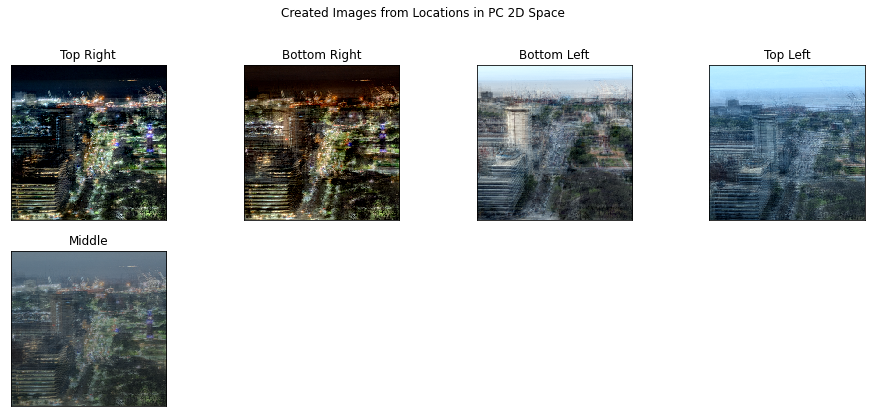

In [6]:
# Finding image far away from samples
# transform image to save sample
locations = [[80000, 25000], [80000, -20000],[-20000, -20000],[-20000, 25000],[30000, 5000]]
reshaped = format_transformed_images(locations)




# plot sample
plot_reconstructed(reshaped, "Created Images from Locations in PC 2D Space", 
                   ["Top Right", "Bottom Right", "Bottom Left","Top Left","Middle"])


## Extension

### Linear Regression

In [7]:
from PIL import Image
from PIL.ExifTags import TAGS


# importing datetime module
import datetime
import time

# Pulling the timestamp of each picture

def get_timestamp(folder):
    y = []
    for image in folder:
        ret = {}
        i = Image.open(image)
        # Getting metadata
        info = i._getexif()
        for tag, value in info.items():
            decoded = TAGS.get(tag, tag)
            ret[decoded] = value
        # Getting only the timestamp
        date = ret['DateTimeOriginal']
        #Converting to unixtime
        date_time = datetime.datetime.strptime(date, '%Y:%m:%d %H:%M:%S').time()
        minutes_since_midnight = date_time.hour*60 + date_time.minute
        #unix_time = time.mktime(time.timetuple())
        y.append(minutes_since_midnight)
    return y

y = get_timestamp(file)
print(y)

[1239, 864, 728, 738, 1117, 802, 1141, 839, 763, 670, 728, 1238, 1117, 865, 1141, 615, 802, 763, 665, 839]


In [8]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(transformed, y)

print('Using sklearn: Rˆ2: {}'.format(reg.score(transformed, y)))

import statsmodels.api as sm
duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")

X_model = sm.add_constant(transformed)
model = sm.OLS(y,X_model)
results = model.fit()
print("Summary with statsmodels")
results.summary()


Using sklearn: Rˆ2: 0.4712616418267167
Summary with statsmodels


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     7.576
Date:                Sat, 01 Oct 2022   Prob (F-statistic):            0.00444
Time:                        01:34:25   Log-Likelihood:                -127.66
No. Observations:                  20   AIC:                             261.3
Df Residuals:                      17   BIC:                             264.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        883.7000     34.731     25.444      0.000     810.424     956.976
x1             0.0050      0.001      3.682      0.002       0.002       0.008
x2            -0.0029      0.002     -1.263      0.224      -0.008       0.002
==============================================================================
Omnibus:                        2.391   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.266
Skew:                           0.262   Prob(JB):                        0.531
Kurtosis:                       1.885   Cond. No.                     2.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We get an R squared of .471, which means 47% of the variance in the data is explained by the model. Investigating the coefficients, we see that the first vector x1 has a positive coefficient, meaning that the higher the value the later in the day the picture is. This matches our previous observation that the main component measured how dark the picture is (since dark=late). The second component, which seems to measure how "orange" the picture is, it not as important in the regression (p_value of 0.2) and also matches intuition: the lower the value of the vector, the more orange the picture is, and the later in the day it was taken (closer to sunset).

### Classification

In [9]:
# Making an array of whether the image was taken later than the first half of the photos (based only on time of day)
y2 = np.array(y)>np.median(y)
y2

array([ True,  True, False, False,  True, False,  True,  True, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False,  True])

              precision    recall  f1-score   support

       False       0.75      0.60      0.67         5
        True       0.50      0.67      0.57         3

    accuracy                           0.62         8
   macro avg       0.62      0.63      0.62         8
weighted avg       0.66      0.62      0.63         8



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



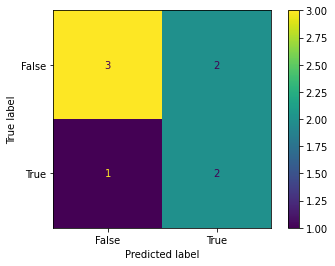

In [10]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score




# Function to predict and evaluate the performace of the model
def evaluate(fitted_model, X_test, y_test):
    y_pred = fitted_model.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division = 0))

    plot_confusion_matrix(fitted_model, X_test, y_test)  
    plt.show()

X = transformed

X_train, X_test, y_train, y_test = train_test_split(
    X, y2, test_size=0.40, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)

evaluate(model, X_test, y_test)


In [11]:
# Cross Validation
scores = cross_val_score(model, X, y2, cv = 5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.55 accuracy with a standard deviation of 0.10


The Logistic Regression does not perform well, with an accuracy of only 55%. I believe that components chosen to describe the images made the task of classifying time of day hard, especially PC2, which describes the "orangeness" of the image. This is because the photo could be more orange either because it's sunset time or because the day is cloudy and it's the morning, so the component not correlate well with time of day. 